# CAP Training Tutorial

This notebook demonstrates how to train a CAP model using the framework. We'll walk through the process step by step, explaining each component and allowing for interactive experimentation.

### 1. Import Required Libraries

In [17]:
import os
import sys
# Add the parent directory to the path if needed
sys.path.append(os.path.abspath('/home/yeqchen/cap/cap-Data_Processing/'))

In [18]:
import torch
import torch.nn as nn
import cap
from cap import *
import matplotlib.pyplot as plt
import numpy as np
import yaml

### 2. Set Up Device and Load Data

In [19]:
# Load Configuration
config_path = '../cap/configs/ett_config.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

# Print configuration
print("Configuration:")
print(f"Dataset: {config['dataset']['path']}")
print(f"Model: {config['model']['type']}")
print(f"Training: {config['training']['epochs']} epochs, {config['training']['device']}")

Configuration:
Dataset: ../dataset/ElectricityTransformer/ETTh1.csv
Model: lstm
Training: 50 epochs, cuda


In [20]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load data
# Get dataloaders
train_loader, valid_loader, test_loader = cap.get_dataloaders(
        path=config['dataset']['path'],
        batch_size=config['dataset']['batch_size'],
        shuffle=True,
        train_size=config['dataset']['train_size'],
        valid_size=config['dataset']['valid_size'],
        test_size=config['dataset']['test_size'],
        model_type=config['model']['type'],
        normalization=config['dataset'].get('normalization', True),
        seq_len  = config['model']['seq_len'],
        pred_len = config['model']['pred_len']
    )

Using device: cuda


### 3. Analyze Data Dimensions

Input dimension: 7
Output dimension: 1
Sequence length: 96
Prediction length: 96


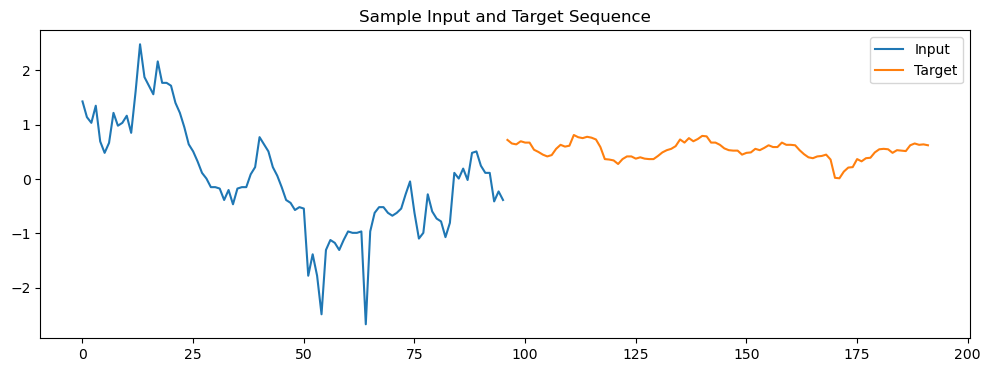

In [21]:
# Get input dimensions from first batch
for batch in train_loader:
    inputs, targets = batch
    input_dim = inputs.shape[-1]
    output_dim = targets.shape[-1]
    seq_len = inputs.shape[1]
    pred_len = targets.shape[1]
    break

print(f"Input dimension: {input_dim}")
print(f"Output dimension: {output_dim}")
print(f"Sequence length: {seq_len}")
print(f"Prediction length: {pred_len}")

# Visualize a sample from the dataset
plt.figure(figsize=(12, 4))
plt.plot(inputs[0, :, 0].numpy(), label='Input')
plt.plot(range(seq_len, seq_len + pred_len), targets[0, :, 0].numpy(), label='Target')
plt.title('Sample Input and Target Sequence')
plt.legend()
plt.show()

### 4. Define Worker Configurations

We'll create a pool of workers with different architectures:
- Two LSTM workers with different hidden dimensions
- One Transformer worker"

In [22]:
# Define worker configurations
worker_configs = [
    # LSTM Workers
    {
        'model_name': 'lstm',
        'input_dim': input_dim,
        'hidden_dim': 256,
        'num_layers': 2,
        'output_dim': output_dim,
        'dropout': 0.1
    },
    {
        'model_name': 'lstm',
        'input_dim': input_dim,
        'hidden_dim': 64,
        'num_layers': 2,
        'output_dim': output_dim,
        'dropout': 0.15
    },
    # Transformer Worker
    {
        'model_name': 'transformer',
        'input_dim': input_dim,
        'output_dim': output_dim,
        'seq_len': seq_len,
        'pred_len': pred_len,
        'd_model': 128,
        'n_heads': 4,
        'd_ff': 256,
        'num_layers': 2,
        'dropout': 0.1
    }
]

In [23]:
print("Worker Configurations:")
for i, config in enumerate(worker_configs):
    print(f"\nWorker {i}:")
    for key, value in config.items():
        print(f"  {key}: {value}")

Worker Configurations:

Worker 0:
  model_name: lstm
  input_dim: 7
  hidden_dim: 256
  num_layers: 2
  output_dim: 1
  dropout: 0.1

Worker 1:
  model_name: lstm
  input_dim: 7
  hidden_dim: 64
  num_layers: 2
  output_dim: 1
  dropout: 0.15

Worker 2:
  model_name: transformer
  input_dim: 7
  output_dim: 1
  seq_len: 96
  pred_len: 96
  d_model: 128
  n_heads: 4
  d_ff: 256
  num_layers: 2
  dropout: 0.1


### 5. Create Models

Create the worker models and the manager model that will coordinate between them.

In [24]:
 # Create worker models
worker_models = cap.catp.create_worker_pool(worker_configs, cap.catp.available_models())

# Create manager model
manager_model = cap.catp.ManagerModel(
    input_dim=input_dim,
    worker_count=len(worker_models),
    d_model=256,
    n_heads=4,
    d_ff=1024,
    num_layers=2,
    dropout=0.2
)

print(f"Created {len(worker_models)} worker models and 1 manager model")


Created 3 worker models and 1 manager model


### 6. Initialize Trainer

Create the CATP trainer with default optimizers and custom learning rates.

In [25]:
# Create trainer with default optimizers
trainer = cap.catp_trainer.CATPTrainer(
    manager_model=manager_model,
    worker_models=worker_models,
    criterion=nn.MSELoss(),
    device=device,
    manager_lr=0.005,  # Manager learning rate
    worker_lr=0.001    # Worker learning rate
)

### 7. Train the Model

Train the model with early stopping and metric plotting enabled.


Epoch 1/15
Current learning rates - Manager: 0.005000, Worker: 0.001000
  Batch 0: Worker Loss = 2.0289, Manager Loss = 3.8731
  Batch 10: Worker Loss = 1.8963, Manager Loss = 3.2879
  Batch 20: Worker Loss = 0.5664, Manager Loss = 3.0250
  Batch 30: Worker Loss = 0.9373, Manager Loss = 2.9916
  Batch 40: Worker Loss = 0.7764, Manager Loss = 2.9856
  Batch 50: Worker Loss = 0.6238, Manager Loss = 2.9784
  Batch 60: Worker Loss = 1.3557, Manager Loss = 2.9799
  Batch 70: Worker Loss = 0.7698, Manager Loss = 2.9772
  Batch 80: Worker Loss = 0.7750, Manager Loss = 2.9772
  Batch 90: Worker Loss = 0.5886, Manager Loss = 2.9771
  Batch 100: Worker Loss = 0.6802, Manager Loss = 2.9769
  Batch 110: Worker Loss = 1.6219, Manager Loss = 2.9768
  Batch 120: Worker Loss = 0.6807, Manager Loss = 2.9769
  Batch 130: Worker Loss = 1.0154, Manager Loss = 2.9770
  Batch 140: Worker Loss = 1.0528, Manager Loss = 2.9767
  Batch 150: Worker Loss = 0.5017, Manager Loss = 2.9765
  Batch 160: Worker Loss =

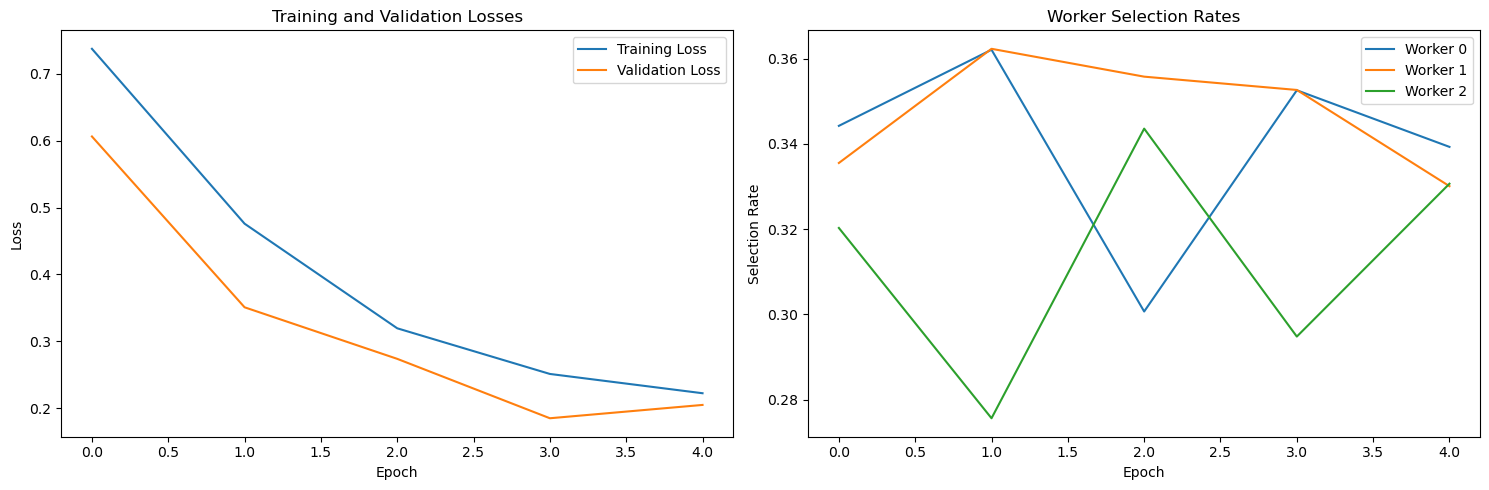


Epoch 6/15
Current learning rates - Manager: 0.002683, Worker: 0.000540
  Batch 0: Worker Loss = 0.2568, Manager Loss = 3.2749
  Batch 10: Worker Loss = 0.2046, Manager Loss = 3.2749
  Batch 20: Worker Loss = 0.3787, Manager Loss = 3.2749
  Batch 30: Worker Loss = 0.1550, Manager Loss = 3.2749
  Batch 40: Worker Loss = 0.3253, Manager Loss = 3.2749
  Batch 50: Worker Loss = 0.1650, Manager Loss = 3.2749
  Batch 60: Worker Loss = 0.2149, Manager Loss = 3.2749
  Batch 70: Worker Loss = 0.1830, Manager Loss = 3.2749
  Batch 80: Worker Loss = 0.1960, Manager Loss = 3.2749
  Batch 90: Worker Loss = 0.2387, Manager Loss = 3.2749
  Batch 100: Worker Loss = 0.2149, Manager Loss = 3.2749
  Batch 110: Worker Loss = 0.2041, Manager Loss = 3.2749
  Batch 120: Worker Loss = 0.2019, Manager Loss = 3.2749
  Batch 130: Worker Loss = 0.2277, Manager Loss = 3.2749
  Batch 140: Worker Loss = 0.1320, Manager Loss = 3.2749
  Batch 150: Worker Loss = 0.4981, Manager Loss = 3.2749
  Batch 160: Worker Loss =

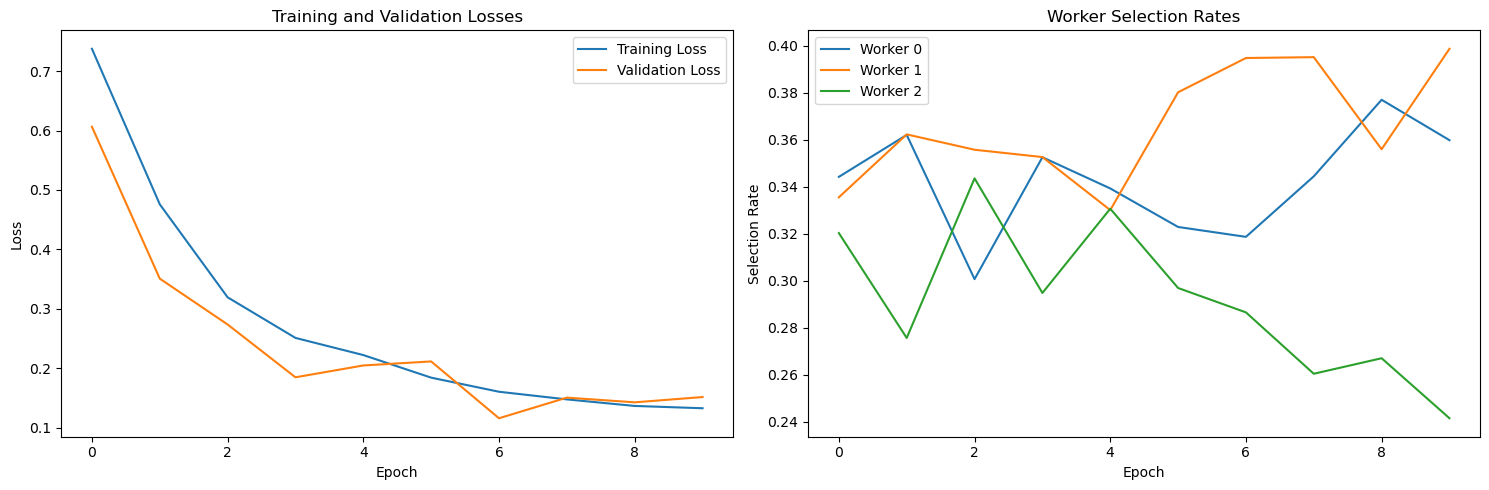


Epoch 11/15
Current learning rates - Manager: 0.000047, Worker: 0.000017
  Batch 0: Worker Loss = 0.1044, Manager Loss = 3.2749
  Batch 10: Worker Loss = 0.1189, Manager Loss = 3.2749
  Batch 20: Worker Loss = 0.1123, Manager Loss = 3.2749
  Batch 30: Worker Loss = 0.1201, Manager Loss = 3.2749
  Batch 40: Worker Loss = 0.1062, Manager Loss = 3.2749
  Batch 50: Worker Loss = 0.0787, Manager Loss = 3.2749
  Batch 60: Worker Loss = 0.1238, Manager Loss = 3.2749
  Batch 70: Worker Loss = 0.0805, Manager Loss = 3.2749
  Batch 80: Worker Loss = 0.1352, Manager Loss = 3.2749
  Batch 90: Worker Loss = 0.0976, Manager Loss = 3.2749
  Batch 100: Worker Loss = 0.1340, Manager Loss = 3.2749
  Batch 110: Worker Loss = 0.1389, Manager Loss = 3.2749
  Batch 120: Worker Loss = 0.1046, Manager Loss = 3.2749
  Batch 130: Worker Loss = 0.1386, Manager Loss = 3.2749
  Batch 140: Worker Loss = 0.1093, Manager Loss = 3.2749
  Batch 150: Worker Loss = 0.1502, Manager Loss = 3.2749
  Batch 160: Worker Loss 

In [26]:
# Train the model
history = trainer.train(
    train_loader=train_loader,
    val_loader=valid_loader,
    epochs=15,
    checkpoint_dir='checkpoints/cap',
    early_stopping_patience=5,  # Stop if no improvement for 5 epochs
    plot_metrics=True           # Show training plots
)